# Network Analysis

In [1]:
from nipype.pipeline.engine import Workflow, Node, JoinNode, MapNode
from nipype.interfaces.utility import IdentityInterface, Function
from nipype.interfaces.io import SelectFiles, DataSink, DataGrabber
from glob import glob

# MATLAB setup - Specify path to current SPM and the MATLAB's default mode
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('~/spm12/toolbox')
MatlabCommand.set_default_matlab_cmd("matlab -nodesktop -nosplash")

# FSL set up- change default file output type
from nipype.interfaces.fsl import FSLCommand
FSLCommand.set_default_output_type('NIFTI_GZ')

# Study-specific variables
project_home = '/data/perlman/moochie/user_data/CamachoCat'
output_dir = project_home + '/combinedDWI/network_analysis'
workflow_dir = project_home + '/combinedDWI/workflows'
chec_dir = project_home + '/ChEC/dmri_proc/proc/preprocessing/dsi_studio'
emogrow_dir = project_home + '/EmoGrow/dMRI_proc/proc/preprocessing/dsi_studio'

atlas = '/usr/local/pkg/dsistudio/atlas/MMP_subcort.nii.gz'
atlas_key = project_home + '/combinedDWI/template/MMP_subcort.csv'
stress_data = project_home + '/combinedDWI/stress_data/dwi_sample_LEQ_summary_scores_20201116.csv'

201116-13:25:10,814 nipype.utils INFO:
	 Running nipype version 1.4.2 (latest: 1.5.1)


### Collect all the connectivity map files

In [21]:
chec_files = glob(chec_dir + '/*/*.connectogram.txt')
emogrow_files = glob(emogrow_dir + '/*/*.connectogram.txt')

connect_files = chec_files + emogrow_files
len(connect_files)

103

### Identify group-level networks

/data/perlman/moochie/resources/mri_scripts/mri_proc_env/lib/python3.8/site-packages/nilearn/plotting/matrix_plotting.py:107: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(mat, method=reorder)
/data/perlman/moochie/resources/mri_scripts/mri_proc_env/lib/python3.8/site-packages/nilearn/plotting/matrix_plotting.py:108: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  ordered_linkage = optimal_leaf_ordering(linkage_matrix, mat)


<Figure size 432x288 with 0 Axes>

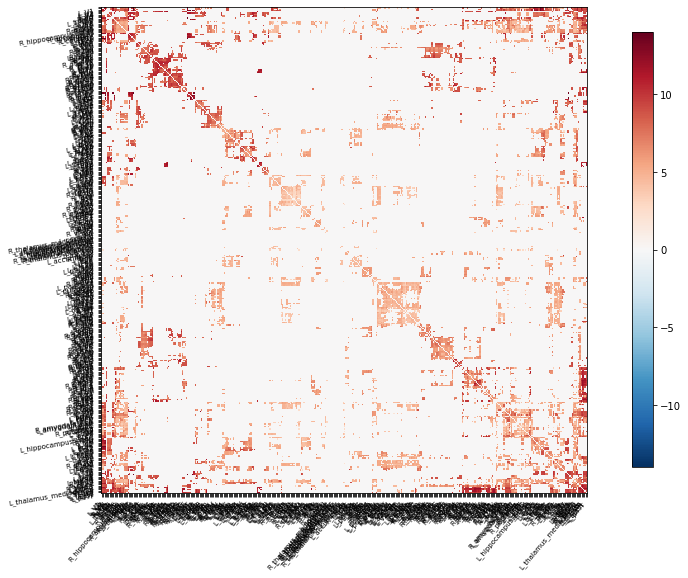

In [80]:
import numpy as np
import pandas as pd
from nilearn import plotting
import matplotlib.pyplot as plt

# load up all the subject-level connectivity maps
first = pd.read_csv(connect_files[0],index_col=1,header=1,skiprows=0, sep='\t')
first = first.drop(columns=['data','Unnamed: 386'])
group_data = first.to_numpy()
group_data = np.expand_dims(group_data, axis=2)

# average the connectivity maps and cluster
for file in connect_files[1:]:
    temp = pd.read_csv(connect_files[0],index_col=1,header=1,skiprows=0, sep='\t')
    temp = temp.drop(columns=['data','Unnamed: 386'])
    temp = np.expand_dims(temp.to_numpy(), axis=2)
    group_data = np.concatenate((group_data,temp), axis=2)

mean_conn_data = np.average(group_data,axis=2)

# visualize the connectivity matrix
plt.figure()
plotting.plot_matrix(mean_conn_data, figure=(10,10), labels=first.index.to_list(), 
                     vmin=-14,vmax=14,reorder=True)
plt.savefig('mean_parcel_connect.svg')
plt.show()

# save mean connectivity matrix
mean_conn =pd.DataFrame(mean_conn_data, index=first.index, columns = first.index)
mean_conn.to_csv(output_dir + '/mean_conn_mat.csv')

In [24]:
# detect community structure using iterative louvain procedure
import bct
import nibabel as nib
labels = pd.read_csv(atlas_key, sep='\s',index_col=None, header=None,names=['parcelnum','parcelname'])
parcels = 

mean_conn = pd.read_csv(output_dir + '/mean_conn_mat.csv', index_col=0)
mean_conn_data = mean_conn.to_numpy()

mods = []
nets = []
for seed in range(0,100):
    t_net = bct.modularity.community_louvain(mean_conn_data, gamma=1.5, ci=None, B='modularity', seed=seed)
    mods.append(t_net[1])
    nets.append(t_net[0])

final_conns = np.zeros_like(mean_conn_data)

for parc in parcels:
    
networks = bct.modularity.community_louvain(mean_conn_data, gamma=1.5, ci=None, B='modularity', seed=seed)

[0.3115325624067186,
 0.31795766856710367,
 0.31266567326556083,
 0.3165371412749084,
 0.3200006459112971,
 0.3176720530297535,
 0.3231511509345207,
 0.3156930363707837,
 0.32182964649084383,
 0.3174651441485985,
 0.3174404586698019,
 0.30612762874309263,
 0.3157317768060968,
 0.3191530665288174,
 0.3175275613047412,
 0.3132694881322215,
 0.3180174611549347,
 0.3146327778475738,
 0.3152850677355058,
 0.3200375031602752,
 0.31175014110167454,
 0.3156086086086987,
 0.3149035561175852,
 0.313238989868107,
 0.3212353344056888,
 0.323477457682638,
 0.3170240156472703,
 0.3188853367831406,
 0.3132066094044652,
 0.3224123073305856,
 0.32030190037500783,
 0.3142797497670538,
 0.3165276054224736,
 0.31885093449430274,
 0.3170386138936999,
 0.3171772495505419,
 0.31064060833757057,
 0.3195087390325348,
 0.31967618305385304,
 0.3173922244779981,
 0.3114398858441499,
 0.31816601401610817,
 0.314171249927228,
 0.31705525523911315,
 0.31609996267701224,
 0.31760102669394524,
 0.31918551799748834,
 0

[array([ 6,  2,  6,  6,  6,  2,  6,  4,  4,  2,  2,  2,  2,  1,  6,  2,  6,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  4,  2,  4,  4,  1,  4,  1,  4,
        4,  4,  4,  1,  4,  4,  1,  4,  4,  2,  4,  4,  2,  2,  4,  4,  2,
        2,  2,  2,  4,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,
        1,  1,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  1,  2,  1,  2,  2,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  6,  6,  6,  6,
        2,  2,  2,  6,  6,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        6,  2,  2,  6,  2,  2,  2,  2,  2,  6,  6,  6,  2,  2,  2,  6,  4,
        4,  6,  1,  1,  1,  2,  2,  2,  2,  6,  2,  2,  2,  2,  2,  1,  1,
        3,  7,  7,  3,  3,  3,  3,  7,  7,  7,  5,  7,  7,  1,  6,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  5,  4,  7,  4,  4,  1,  4,  1,  4,
        4,  4,  4,  4,  4,  4,  4,  7,  1,  5,  4,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  4,  

In [28]:
# add the network information to the labels and save
labels = pd.read_csv(atlas_key, sep='\s',index_col=None, header=None,names=['parcelnum','parcelname'])
labels['networknum'] = networks[0]
labels.to_csv(output_dir + '/parcels_network_link_labels.csv')

# save a labeled volume of the networks
parcel_img = nib.load(atlas)
parcel_data = parcel_img.get_fdata()
network_data = parcel_img.get_fdata()

for a in labels.index:
    network_data[parcel_data==labels.loc[a,'parcelnum']]=labels.loc[a,'networknum']

network_img = nib.Nifti1Image(network_data,affine=parcel_img.affine, header=parcel_img.header)
nib.save(network_img, output_dir + '/network_vol_link.nii.gz')

<ipython-input-28-ef5504d54b0b>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  labels = pd.read_csv(atlas_key, sep='\s',index_col=None, header=None,names=['parcelnum','parcelname'])
<ipython-input-28-ef5504d54b0b>:12: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  network_data[parcel_data==labels.loc[a,'parcelnum']]=labels.loc[a,'networknum']


### Compute subject level network measures and aggregate them together

In [29]:
# Sink data of interest 
substitutions = [('_connectogram_..data..perlman..moochie..user_data..CamachoCat..EmoGrow..dMRI_proc..proc..preprocessing..dsi_studio..', ''),
                 ('..dmri_unwarped.nii.gz.src.gz.odf6.f5rec.bal.csfc.012fy.rdi.gqi.1.15.fib.gz.MMP_subcort.qa.pass.connectogram.txt',''),
                 ('_connectogram_..data..perlman..moochie..user_data..CamachoCat..ChEC..dmri_proc..proc..preprocessing..dsi_studio..',''),
                 ('..dmri_unwarped.nii.gz.src.gz.odf6.f5rec.bal.csfc.012fy.rdi.gqi.1.15.fib.gz.MMP_subcort.qa.pass.connectogram.txt',''),
                 ('_dMRI_98dir_unwarped.src.odf6.f5rec.bal.csfc.012fy.rdi.gqi.1.15.fib.gz.MMP_subcort.qa.pass.connectogram.txt','')]
datasink = Node(DataSink(base_directory = output_dir,
                         substitutions = substitutions,
                         container = output_dir), 
                name='datasink')

In [30]:
def net_connect(connectogram, atlas_info,threshold):
    '''This function takes a connectgram and an atlas with assigned networks and creates
    a connectogram of the network-wide connectivity.

    Inputs:
        connectogram:  the subject's connectogram data.
        atlas_info:  parcellation-network mapping
        threshold:  None or number. NaNs values below this threshold.

    Outputs:
        network_connect: network connectogram  
    '''
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from os.path import abspath
    import numpy as np
    import pandas as pd

    labels_df = pd.read_csv(atlas_info,index_col=0)
    labels_df = labels_df.loc[:,['network','region']]

    t =  pd.read_csv(connectogram,index_col=1,header=1,skiprows=0, sep='\t')
    t = t.drop(columns=['data','Unnamed: 386'])
    t = t.reindex(labels_df['region'].tolist(),columns=labels_df['region'].tolist())
    t.columns = pd.MultiIndex.from_frame(labels_df, names=['network','region'])
    t.index = pd.MultiIndex.from_frame(labels_df, names=['network','region'])
    if np.isfinite(threshold):
        t[t==threshold]= np.nan
    t = t.groupby(level=0).mean()
    t = t.groupby(level=0, axis=1).mean()
    t = t.drop(labels=['none'], axis=0)
    t = t.drop(labels=['none'], axis=1)
    t.to_csv('network_connectogram.csv')
    network_connect = abspath('network_connectogram.csv')
    return(network_connect)

def combine_sample_connect(sub_net_conn_files):
    '''This function takes a list of subject-level adjacency matrices and compiles
    them to a single csv.

    Inputs:
        sub_net_conn_files:  list of subject file names (each a pandas dataframe csv)

    Outputs:
        sample_connect: sample aggregate of connectivity values 
    '''
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from os.path import abspath, dirname,split
    import pandas as pd
    import numpy as np

    
    temp = pd.read_csv(sub_net_conn_files[0], index_col=0)
    regions = temp.columns.to_list()
    col_names = []
    k=0
    while k<len(regions):
        for b in range(k+1,len(regions)):
            col_names.append('{0}_{1}'.format(regions[k].replace('_',''),regions[b].replace('_','')))
        k=k+1
    sample_connect_df = DataFrame(columns = col_names)
    
    for file in sub_net_conn_files:
        sub = file.split('dsi_studio..',1)[1][:,5]
        temp = pd.read_csv(file, index_col=0)
        k=0
        while k < len(regions):
            for b in range(k+1,len(regions)):
                sample_connect_df.loc[sub,'{0}_{1}'.format(regions[k].replace('_',''),
                                                          regions[b].replace('_',''))]=temp.loc[regions[k],regions[b]]
            k=k+1 
    
    sample_connect.to_csv('full_sample_connectivity.csv')
    sample_connect = abspath('full_sample_connectivity.csv')
    return(sample_connect)

In [31]:
make_network_matrix = Node(Function(input_names=['connectogram', 'atlas_info', 'threshold'], 
                                    output_names=['network_connect'],
                                    function=net_connect), 
                           name='make_network_matrix')
make_network_matrix.inputs.atlas_info = atlas_key
make_network_matrix.inputs.threshold = 0
make_network_matrix.iterables=[('connectogram',connect_files)]

combine_sample_conn = JoinNode(Function(input_names=['sub_net_conn_files'], 
                                        output_names=['sample_connect'],
                                        function=combine_sample_connect), 
                               name='combine_sample_conn', 
                               joinfiled='sub_net_conn_files',
                               joinsource='make_network_matrix')

In [ ]:
connect_flow = Workflow(name='connect_flow')
connect_flow.connect([(make_network_matrix, datasink, [('network_connect','subject_network_connect')])
                     ])

connect_flow.base_dir = workflow_dir
connect_flow.run('MultiProc', plugin_args={'n_procs': 4, 'memory_gb':30})

In [33]:
from glob import glob
import pandas as pd

sub_net_conn_files = glob('/data/perlman/moochie/user_data/CamachoCat/combinedDWI/workflows/connect_flow/*/make_network_matrix/network_connectogram.csv')
sub_net_conn_files = sorted(sub_net_conn_files)
temp = pd.read_csv(sub_net_conn_files[0], index_col=0)
regions = temp.columns.to_list()
col_names = []
k=0
while k<len(regions):
    for b in range(k,len(regions)):
        col_names.append('{0}_{1}'.format(regions[k].replace('_',''),regions[b].replace('_','')))
    k=k+1
sample_connect_df = pd.DataFrame(columns = col_names)

for file in sub_net_conn_files:
    sub = file.split('dsi_studio..',1)[1][:4]
    temp = pd.read_csv(file, index_col=0)
    k=0
    while k < len(regions):
        for b in range(k,len(regions)):
            sample_connect_df.loc[sub,'{0}_{1}'.format(regions[k].replace('_',''),
                                                      regions[b].replace('_',''))]=temp.loc[regions[k],regions[b]]
        k=k+1 

sample_connect_df.to_csv('full_sample_connectivity.csv')

In [3]:
### Elastic-net model ###

from os.path import abspath
from sklearn.model_selection import permutation_test_score, LeaveOneOut
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import PowerTransformer
import pandas as pd
import numpy as np
from scipy.stats import linregress, spearmanr
from sklearn.metrics import mean_squared_error
from datetime import date
import matplotlib.pyplot as plt
today = date.today()

out_dir = project_home + '/combinedDWI/network_analysis/ENET_results/'
groups_col_name = 'ID'
conditions = ['LEQ_tot_neg','LEQ_wprox_neg']
labels_df = pd.read_csv(stress_data,index_col=None)
X = pd.read_csv(out_dir+'full_sample_connectivity.csv', index_col=None)
X=X[labels_df['scan_age']>5.5]
labels_df=labels_df[labels_df['scan_age']>5.5]
X=X.drop(columns='ID')
tf = PowerTransformer()

for condition in conditions:
    labels_df[condition + '_yj'] = tf.fit_transform(labels_df[condition].to_numpy().reshape(-1,1))
    results_file = open(out_dir+'results_{0}_{1}.txt'.format(condition,today.strftime('%Y%m%d')),'w')
    
    loso = LeaveOneOut()
    enet = ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 0.9, 1], fit_intercept=True, cv=loso, n_jobs=10, 
                        random_state=42).fit(X,labels_df[condition + '_yj'])
    y_pred = enet.predict(X)

    # save the labels_df with the new y_pred data
    labels_df['{0}_predicted'.format(condition)] = y_pred
    
    ## Calculate measures of model fit
    # Use linear regression to estimate linear association between predicted and actual labels
    slope, intercept, r_val, p_val, stderr = linregress(labels_df[condition+ '_yj'], labels_df['{0}_predicted'.format(condition)])
    # Compute mean square error
    mse = mean_squared_error(labels_df[condition+ '_yj'], labels_df['{0}_predicted'.format(condition)])
    # Compute spearman (nonparametric) correlation
    spear_r, spear_p = spearmanr(labels_df[condition+ '_yj'], labels_df['{0}_predicted'.format(condition)])
    # Write results to the results text files
    results_file.write("linear beta={0}, p={1}, MSE:{2} \n".format(round(r_val,3), round(p_val,3), round(mse,3)))
    results_file.write('Spearman r={0}, p={1}'.format(round(spear_r,3), round(spear_p,3)))
    results_file.close()

    # save weights
    np.save(out_dir+'weights{0}.npy'.format(condition),enet.coef_)
    svr_results_file = abspath(out_dir+'weights.npy')
    weights_df = pd.DataFrame(0, index=[0],columns=X.columns)

    weights_df.iloc[0,:]=enet.coef_
    weights_df.to_csv(out_dir+'weights_df_{0}_{1}.csv'.format(condition,today.strftime('%Y%m%d')))

    #plot predicted versus actual
    plt.scatter(labels_df[condition+ '_yj'], labels_df['{0}_predicted'.format(condition)])
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.savefig(out_dir+'scatter_pred_actual_{0}_{1}.svg'.format(condition,today.strftime('%Y%m%d')))
    plt.close()
labels_df.to_csv(out_dir+'labeling_results.csv')

In [4]:
def weights_to_adjmatrix(model_weights,sample_file):
    '''This function takes a list of subject-level adjacency matrices and compiles
    them to a single csv.

    Inputs:
        sub_net_conn_files:  list of subject file names (each a pandas dataframe csv)

    Outputs:
        sample_connect: sample aggregate of connectivity values 
    '''
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from nilearn.plotting import plot_matrix
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    import seaborn as sns

    weights = pd.read_csv(model_weights, index_col=0)
    sample_connect_df = pd.read_csv(sample_file, index_col=0)
    regions = sample_connect_df.columns.to_list()
    weights_adj_mat = pd.DataFrame(columns=sample_connect_df.columns,index=sample_connect_df.columns)
    
    for k in range(0,len(regions)):
        for b in range(0,len(regions)):
            if '{0}_{1}'.format(regions[k].replace('_',''),regions[b].replace('_','')) in weights.columns:
                weights_adj_mat.loc[regions[k],regions[b]] = weights.loc[weights.index[0],'{0}_{1}'.format(regions[k].replace('_',''),regions[b].replace('_',''))]
    
    weights_adj_mat.to_csv(model_weights[:-4]+'_adjmat.csv')
    weights_adj_mat[pd.isnull(weights_adj_mat)]=0
    weights_adj = weights_adj_mat.to_numpy()
    
    cmap = sns.diverging_palette(230,20,as_cmap=True)
    sns.heatmap(weights_adj_mat.astype(float),center=0, cmap=cmap)
    plt.savefig(model_weights[:-4]+'_adjmat.svg')
    plt.close()


sample_file='/data/perlman/moochie/user_data/CamachoCat/combinedDWI/network_analysis/subject_network_connect/1000/network_connectogram.csv'
weights=['weights_df_LEQ_tot_neg_20201116.csv','weights_df_LEQ_wprox_neg_20201116.csv']
for w in weights:
    weights_to_adjmatrix(out_dir+w,sample_file)

<Figure size 432x288 with 0 Axes>

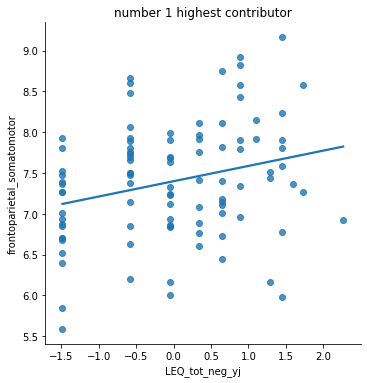

<Figure size 432x288 with 0 Axes>

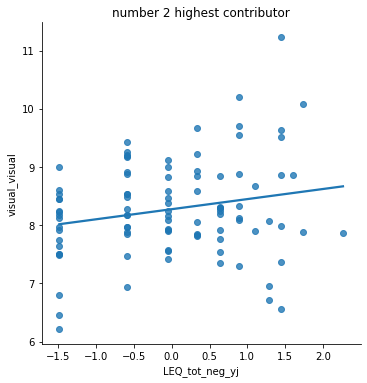

['frontoparietal_somatomotor', 'visual_visual']


<Figure size 432x288 with 0 Axes>

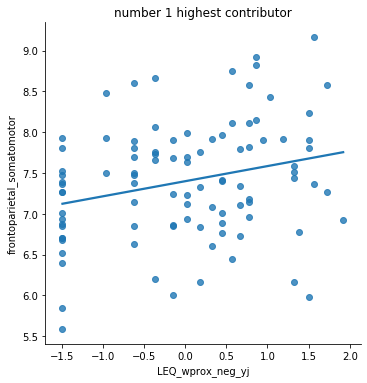

<Figure size 432x288 with 0 Axes>

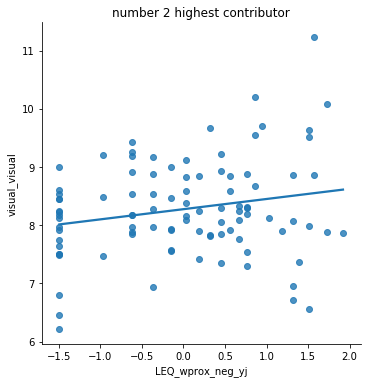

['frontoparietal_somatomotor', 'visual_visual']


In [6]:
## plot the associations found in the previous models
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

out_dir = project_home+'/combinedDWI/network_analysis/ENET_results/'
sample_data = pd.read_csv(out_dir + 'full_sample_connectivity.csv', index_col=None)
stress_data = pd.read_csv(out_dir + 'labeling_results.csv',index_col=0)
full_data = sample_data.merge(stress_data,on='ID')
#num_weights_exam = 5
conditions = ['LEQ_tot_neg','LEQ_wprox_neg']

for con in conditions:
    weights = pd.read_csv(out_dir + 'weights_df_{0}_20201116.csv'.format(con))
    weights = weights.abs()
    top_weights = []
    i=1
    a=0
    while i==1:
        if (weights.max(axis=1)>0).any():
            top_weights.append(weights.idxmax(axis=1).to_list()[0]) #identify the highest weight
            plt.figure()
            sns.lmplot(x=con + '_yj',y=weights.idxmax(axis=1).to_list()[0],data=full_data, ci=None)
            plt.title('number {0} highest contributor'.format(a+1))
            plt.savefig(out_dir+'{0}_feature{1}_lmplot.png'.format(con,a+1))
            plt.show()
            plt.close()
            weights = weights.drop(weights.idxmax(axis=1),axis=1)
            a=a+1
        else:
            i=0
    print(top_weights)